In [210]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import pandas as pd

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/dtypes.py:585: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


RuntimeError: Failed to import transformers.models.auto because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
import faiss

In [39]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)


def get_embedding(batch, tok, model):
    encoded_input = tok(batch, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    return sentence_embeddings
    
# print("Sentence embeddings:")
# print(sentence_embeddings)

SyntaxError: invalid syntax (<ipython-input-158-bfd5aa65a2ee>, line 1)

In [252]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

#Define the model. Either from scratch of by loading a pre-trained model
model = SentenceTransformer('all-mpnet-base-v2')

#Define your train examples. You need more than just two examples...
train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

#Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100)

In [218]:
%pip install numpy==1.22 --upgrade

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [254]:
import pandas as pd
import numpy as np

ref = pd.read_csv('clean_ref.csv')
pairs = pd.read_csv('clean_train.csv')

TRAIN_RATIO = 0.8
TRAIN_SPLIT_SEED = 0

np.random.seed(TRAIN_SPLIT_SEED)
train = np.random.rand(pairs.shape[0]) < TRAIN_RATIO
pairs_train = pairs[train]
pairs_test = pairs[~train]

pairs_train['supplier_name_fake'] = pairs_train['supplier_name'].sample(frac=1.0).values

<ipython-input-4-2037d5546127>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_train['supplier_name_fake'] = pairs_train['supplier_name'].sample(frac=1.0).values


In [255]:
for i in pairs_train.iterrows():
    print(i[1])
    break

code                                             065.8000.3296
description           Телевизор LED LG 43US662H Direct LED 43"
supplier_name                               Телевизор 43US662H
supplier_name_fake                00000-00-0011131-827 стартер
Name: 0, dtype: object


In [258]:
pos_examples = [InputExample(texts=[p[1]['description'], p[1]['supplier_name']], label=1.0) for p in pairs_train.iterrows()]
neg_examples = [InputExample(texts=[p[1]['description'], p[1]['supplier_name_fake']], label=0.0) for p in pairs_train.iterrows()]

<ipython-input-27-fd6d59420a56>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_train['supplier_name_fake'] = pairs_train['supplier_name'].sample(frac=1.0).values


In [266]:
#!g1.1
import pandas as pd
import numpy as np

import torch

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

# ref = pd.read_csv('clean_ref.csv')
pairs = pd.read_csv('clean_train.csv')

TRAIN_RATIO = 0.8
TRAIN_SPLIT_SEED = 0

np.random.seed(TRAIN_SPLIT_SEED)
train = np.random.rand(pairs.shape[0]) < TRAIN_RATIO
pairs_train = pairs[train]
pairs_test = pairs[~train]

pairs_train['supplier_name_fake'] = pairs_train['supplier_name'].sample(frac=1.0).values

pos_examples = [InputExample(texts=[p[1]['description'], p[1]['supplier_name']], label=1.0) for p in pairs_train.iterrows()]
neg_examples = [InputExample(texts=[p[1]['description'], p[1]['supplier_name_fake']], label=0.0) for p in pairs_train.iterrows()]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

#Define your train examples. You need more than just two examples...
train_examples = pos_examples + neg_examples

#Define your train dataset, the dataloader and the train loss
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

model = SentenceTransformer('all-mpnet-base-v2').to(device)
#Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=5, warmup_steps=100)
model.save('all-mpnet-base-v2_5e_ft.pt')

<ipython-input-1-2ba4f4154138>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_train['supplier_name_fake'] = pairs_train['supplier_name'].sample(frac=1.0).values


cuda






















In [1]:
#!g1.1
import pandas as pd
import numpy as np

import torch

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader, Dataset

def create_embs(ser, BATCH_SIZE=1024):
    sent = ser.values
    embs = []

    i = 0
    while i < len(sent):
        embs.append(model.encode(sent[i:(i+BATCH_SIZE)]))
        i += BATCH_SIZE
    return np.vstack(embs)


ref = pd.read_csv('clean_ref.csv')
pairs = pd.read_csv('clean_train.csv')

TRAIN_RATIO = 0.8
TRAIN_SPLIT_SEED = 0

np.random.seed(TRAIN_SPLIT_SEED)
train = np.random.rand(pairs.shape[0]) < TRAIN_RATIO
pairs_train = pairs[train]
pairs_test = pairs[~train]


model = SentenceTransformer('all-mpnet-base-v2_5e_ft.pt')

BATCH_SIZE = 1024


ref_embs = create_embs(ref['description'])
test_embs = create_embs(pairs_test['supplier_name'])

np.save('3_sbert_finetune/ref_embs.npy', ref_embs)
np.save('3_sbert_finetune/test_embs.npy', test_embs)

In [5]:
ref_embs.shape, test_embs.shape

((293569, 768), (8397, 768))

In [2]:
import faiss

In [7]:
index.d

128

In [9]:
ref_embs = np.load('3_sbert_finetune/ref_embs.npy')
test_embs = np.load('3_sbert_finetune/test_embs.npy')

index = faiss.IndexFlatIP(768)
faiss.normalize_L2(ref_embs)
index.add(ref_embs)
print(index.ntotal)

N = 10

faiss.normalize_L2(test_embs)
dist, ids = index.search(test_embs, N)

pairs_test[[f'best_{i}_dist' for i in range(N)]] = dist
pairs_test[[f'best_{i}_item' for i in range(N)]] = ids

293569


In [10]:
ref['index'] = ref.index
pairs_test = pairs_test \
            .merge(ref[['index', 'description']], on='description') \
            .rename(columns={'index': 'reference_index'})

In [12]:
import matplotlib.pyplot as plt

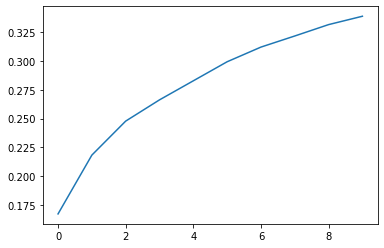

In [13]:
coinside = pairs_test['best_0_item'] == pairs_test['reference_index']
res = [coinside.mean()]
for i in range(1, 10):
    coinside = coinside | (pairs_test[f'best_{i}_item'] == pairs_test['reference_index'])
    res.append(coinside.mean())
    
plt.plot(res)

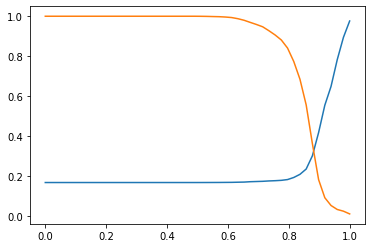

In [15]:
confs = np.linspace(0, 1)
acc = np.zeros_like(confs)
rec = np.zeros_like(confs)

for i, x in enumerate(confs):
    conf_enough = pairs_test['best_0_dist'] > x
    rec[i] = conf_enough.mean()
    acc[i] = (pairs_test['best_0_item'] == pairs_test['reference_index'])[conf_enough].mean()
    
plt.plot(confs, acc)
plt.plot(confs, rec)